# Title

In [8]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

In [2]:
max_dist = 1500
n_bins = 30

df_sif = pd.read_csv("gridded_sif_residuals_north_america.csv")

In [3]:
df_sif

,lon,lat,evi,sif,lon_std,lat_std,evi_std,ols_mean,sif_residuals
0,-124.975,50.725,44250000.0,0.546097,-1.703429,0.779499,0.439474,0.472692,0.073405
1,-124.975,50.775,43360000.0,0.112822,-1.703429,0.785227,0.383525,0.457878,-0.345057
2,-124.975,50.825,43640000.0,0.418302,-1.703429,0.790956,0.401127,0.462612,-0.044310
3,-124.975,50.875,48060000.0,0.401056,-1.703429,0.796684,0.678987,0.536513,-0.135457
4,-124.975,50.925,46360000.0,0.401562,-1.703429,0.802412,0.572118,0.508168,-0.106606
...,...,...,...,...,...,...,...,...,...
48710,-65.025,55.475,34870000.0,0.532294,2.188481,1.323676,-0.150192,0.269610,0.262685
48711,-65.025,57.625,32910000.0,0.070236,2.188481,1.569987,-0.273406,0.257786,-0.187550
48712,-65.025,57.675,27000000.0,0.013305,2.188481,1.575715,-0.644934,0.159578,-0.146273
48713,-65.025,57.725,21960000.0,-0.030751,2.188481,1.581443,-0.961769,0.075906,-0.106657


In [4]:
EARTH_RADIUS = 6371  # radius in kilometers

def distance_matrix(
    X1: np.ndarray, X2: np.ndarray, units: str = "km"
) -> np.ndarray:
    """
    Computes the geodesic (or great circle if fast_dist=True) distance among all pairs of points given two sets of coordinates.
    Wrapper for scipy.spatial.distance.cdist using geopy.distance.geodesic as a the metric.

    NOTE:
    - points should be formatted in rows as [lat, lon]
    - if fast_dist=True, units are kilometers regardless of specification
    """
    # enforce 2d array in case of single point
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    # great circle distances in kilometers
    X1_r = np.radians(X1)
    X2_r = np.radians(X2)
    return haversine_distances(X1_r, X2_r) * EARTH_RADIUS

def cloud_calc(fields: list[np.ndarray]) -> np.ndarray:
    """Calculate the semivariogram or covariogram for all point pairs."""
    center = lambda f: f - f.mean()
    residuals = [center(f) for f in fields]
    cloud = 0.5 * (np.subtract.outer(*residuals)) ** 2
    return cloud

def variogram_cloud(df) -> pd.DataFrame:
    """Calculate the (cross-) variogram cloud for corresponding field id's."""
    dist = distance_matrix(df[["lat", "lon"]].values, df[["lat", "lon"]].values)
    idx = np.triu_indices(dist.shape[0], k=1, m=dist.shape[1])
    dist = dist[idx]
    cloud = cloud_calc([df["sif_residuals"].values, df["sif_residuals"].values])[idx]
    
    return pd.DataFrame({"distance": dist, "variogram": cloud})


def _construct_variogram_bins(
    df_cloud: pd.DataFrame, n_bins: int
) -> tuple[np.ndarray, np.ndarray]:
    """Paritions the domain of a variogram cloud into `n_bins` bins; first bin extended to zero."""
    # use min non-zero dist for consistincy between variograms and cross-variograms
    min_dist = df_cloud[df_cloud["distance"] > 0]["distance"].min()
    max_dist = df_cloud["distance"].max()
    bin_centers = np.linspace(min_dist, max_dist, n_bins)
    bin_width = bin_centers[1] - bin_centers[0]
    bin_edges = np.arange(min_dist - 0.5 * bin_width, max_dist + bin_width, bin_width)
    # check that bin centers are actually centered
    if not np.allclose((bin_edges[1:] + bin_edges[:-1]) / 2, bin_centers):
        warnings.warn("WARNING: variogram bins are not centered.")
    bin_edges[0] = 0
    return bin_centers, bin_edges



def get_variogram(df, max_dist, n_bins) -> pd.DataFrame:
    """Compute the (cross-) variogram of the specified kind for the pair of fields (i, j). Return as a dataframe with bin averages and bin counts."""
    df_cloud = variogram_cloud(df)
    df_cloud = df_cloud[df_cloud["distance"] <= max_dist]
    bin_centers, bin_edges = _construct_variogram_bins(df_cloud, n_bins)
    df_cloud["bin_center"] = pd.cut(
        df_cloud["distance"], bin_edges, labels=bin_centers, include_lowest=True
    )
    df = (
        df_cloud.groupby("bin_center")["variogram"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "bin_mean", "count": "bin_count"})
        .reset_index()
    )
    # convert bins from categories to numeric
    df["bin_center"] = df["bin_center"].astype("string").astype("float")
    if (df["bin_count"] < 30).any():
        warnings.warn(
            f"WARNING: Fewer than 30 pairs used for at least one bin in variogram"
            f" calculation."
        )
    
    return df

In [5]:
df_variogram = get_variogram(df_sif, max_dist, n_bins)
df_variogram

,bin_center,bin_mean,bin_count
0,2.948274,0.025714,531717
1,54.570746,0.030558,1687299
2,106.193219,0.033050,3168278
3,157.815692,0.032318,4756959
4,209.438164,0.034749,5624970
5,261.060637,0.034637,6956807
6,312.683110,0.034738,8463954
7,364.305582,0.035705,9273421
8,415.928055,0.035180,10633933
9,467.550528,0.035394,11515054


<AxesSubplot:xlabel='bin_center', ylabel='bin_mean'>

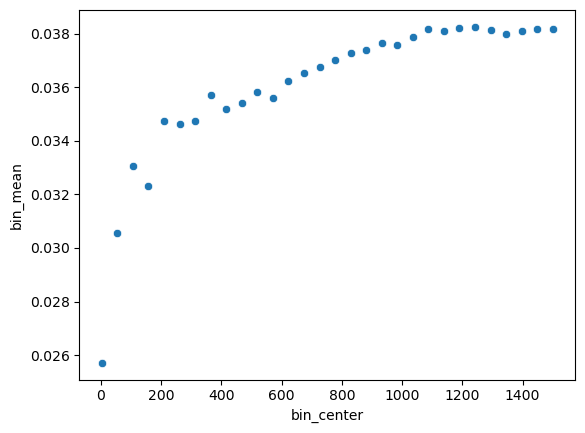

In [10]:
sns.scatterplot(x="bin_center", y="bin_mean", data=df_variogram)

In [6]:
# plot.plot_variograms(mod.fit_result, ["SIF"], title=title)